In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
labels_df = pd.read_csv('/content/drive/MyDrive/projects/chest xrays/sample_labels.csv')
subset_size = 1000 #used small subset only thousand photos because using entire dataset was leading to crash using proper machine and resources and large dataset will lead to higher accuracy
labels_df = labels_df.head(subset_size)

In [7]:
print(labels_df.head())
print(labels_df.info())

        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544           

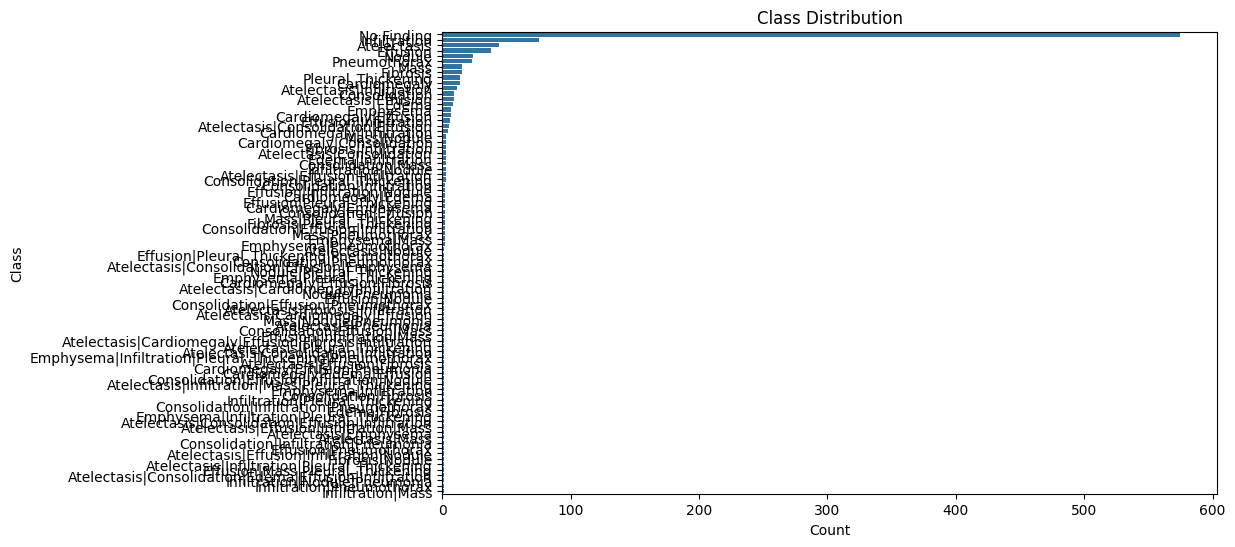

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(y="Finding Labels", data=labels_df, order=labels_df['Finding Labels'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

In [9]:
image_dir = '/content/drive/MyDrive/projects/chest xrays/sample/images'  # Directory containing images
images = []
for img_name in labels_df['Image Index']:
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize images to a common size (adjust as needed)
    images.append(img)
images = np.array(images)

# Normalize images
images = images / 255.0

In [10]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_df['Finding Labels'].apply(lambda x: x.split('|')))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Number of output units matches unique labels
])

In [13]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/model_weights.h5",
                             monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [15]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
23/23 [==============================] - 81s 3s/step - loss: 0.3152 - accuracy: 0.4042 - val_loss: 0.2413 - val_accuracy: 0.5250
Epoch 2/10
23/23 [==============================] - 73s 3s/step - loss: 0.2568 - accuracy: 0.5000 - val_loss: 0.2363 - val_accuracy: 0.5250
Epoch 3/10
23/23 [==============================] - 76s 3s/step - loss: 0.2418 - accuracy: 0.5236 - val_loss: 0.2515 - val_accuracy: 0.5250
Epoch 4/10
23/23 [==============================] - 72s 3s/step - loss: 0.2331 - accuracy: 0.5542 - val_loss: 0.2351 - val_accuracy: 0.5250
Epoch 5/10
23/23 [==============================] - 83s 4s/step - loss: 0.2149 - accuracy: 0.5778 - val_loss: 0.2610 - val_accuracy: 0.5250
Epoch 6/10
23/23 [==============================] - 84s 4s/step - loss: 0.2150 - accuracy: 0.5889 - val_loss: 0.2455 - val_accuracy: 0.5250
Epoch 7/10
23/23 [==============================] - 79s 3s/step - loss: 0.1878 - accuracy: 0.6167 - val_loss: 0.2582 - val_accuracy: 0.5250
Epoch 8/10
23/23 [==

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

7/7 [==============================] - 5s 692ms/step - loss: 0.2940 - accuracy: 0.5200
Test Accuracy: 0.5199999809265137


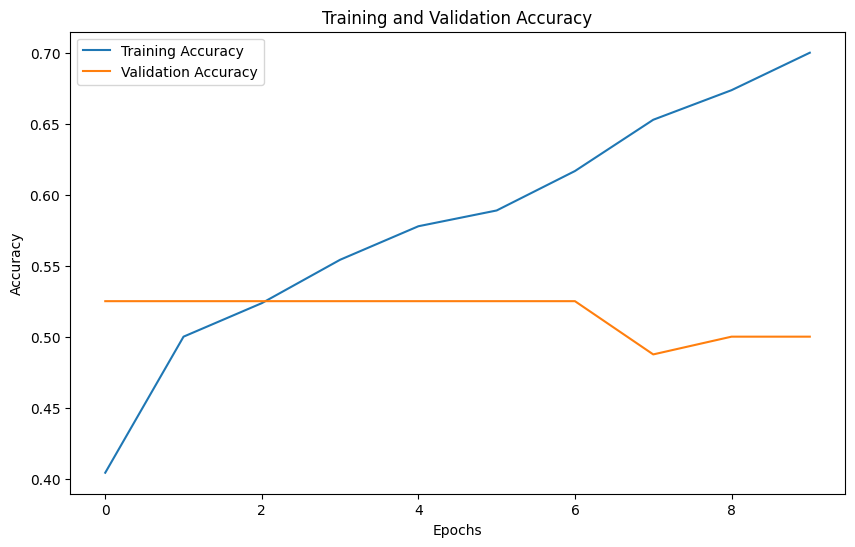

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
model.save_weights("/content/drive/MyDrive/projects/chest xrays/full_model_weights.h5")


In [19]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Number of output units matches unique labels
])

loaded_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Load the weights
loaded_model.load_weights("/content/drive/MyDrive/projects/chest xrays/full_model_weights.h5")


In [28]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Example: replace 'path_to_test_image.jpg' with the actual path to your test image
test_image_path = '/content/drive/MyDrive/projects/chest xrays/sample/images/00004268_007.png'
test_image = load_and_preprocess_image(test_image_path)


In [29]:
predictions = loaded_model.predict(test_image)

# If you have multiple classes, you might want to threshold the predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Convert binary predictions to class labels
predicted_labels = mlb.inverse_transform(binary_predictions)[0]

print("Predicted Labels:", predicted_labels)


1/1 [==============================] - 0s 50ms/step
Predicted Labels: ('Infiltration',)
